# Python Session 3: Introduction to Multinomial Classification

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [5]:
# Load MNIST data
import sklearn.datasets
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [23]:
x_train = torch.tensor(np.array(mnist.data[:60000]), dtype=torch.float)#/255
y_train = torch.tensor([int(x) for x in mnist.target[:60000]])
x_test = torch.tensor(np.array(mnist.data[60000:]), dtype=torch.float)#/255
y_test = torch.tensor([int(x) for x in mnist.target[60000:]])
print(x_train.shape, y_train.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [24]:
mydata = TensorDataset(x_train, y_train)
dataloader= DataLoader(dataset = mydata, batch_size=32, shuffle=True)

## Exercise: 

Normalize the `x_train` and `x_test` so that the inputs are inbetween 0 and 1. While there is easier way, you are recommended to use `MinMaxScaler`.

```
# Example code:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(pre_XX)
XX=scaler.transform(pre_XX)
```

In [13]:
print(x_train.min(), x_train.max())

tensor(0.) tensor(255.)


## 3.1. Classification using Linear model with softmax activation function.

In [15]:
x_train.shape

torch.Size([60000, 784])

### Def 3.1.1. Softmax function

* Softmax function in `torch.nn.Softmax(dim=None)`

Softmax$(x_i)=\frac{\exp(x_i)}{\sum_j\exp(x_j)}$.

### Exercise 3.1.2: 

Apply softmax function to x_train.

In [20]:
# Solution:
m=torch.nn.Softmax(dim=1)
x_softmax = m(x_train)

print(x_softmax[:1, :].sum(), x_softmax[:1, :].shape)

tensor(1.0000) torch.Size([1, 784])


### Def 3.1.3: Cross entropy

* Let `p=P_hat` be the dimension [None, 10] of the predictive probability.
* Let `y=Y_onehot` be the dimension [None, 10] of the one hot-encoded target.
* Then, the cross entropy loss function is defined as 

$
\LARGE
- \sum\limits_{i=1}^N \left(    
  y_{i,0}\log(p_{i,0})+y_{i,1}\log(p_{i,1})+\cdots+y_{i,9}\log(p_{i,9})
  \right)$

### Def 3.1.4: Binary cross entropy
In the logistic regression, your loss function was

$
\Large
-\sum\limits_{i=1}^{N} \left(
 y_{i}\log(p_i) + (1-y_i)\log(1-p_i)
  \right)
$

for `y: [None,]` and `p: [None, ]`. Show that the loss function in the logistic regression is also the cross entropy by transform `y` into one-hot encoded and `p` into the corresponding one. This loss function in the logistic regression is also called as the ***binary cross entropy***.

### Definition of the loss function:

 Now, we do classification for MNIST data with cross entropy loss. Let us start with define the cross entropy loss function with `y: [None, ]` and `y_hat: [None, 10]` where each `y_hat[i, :]`$\in R^{10}$. In the function, we first need to transform the data in the following way:

* `y: [None, ]` into `y_onehot[None, 10]`
* `y_hat[i, :]`$\in R^{10}$ into `y_hat_softmax[i, :]`$\in (0,1)^{10}$ by softmax function.

In [57]:
def loss_ftn(y_hat, y):
  y_onehot = torch.nn.functional.one_hot(y, num_classes=10) # [None,] --> [None, 10]
  m=torch.nn.Softmax(dim=1)
  y_hat_softmax = m(y_hat)
  loss = - torch.mean(  torch.sum( torch.log(y_hat_softmax)*y_onehot, axis=1) )
  return loss

You can do the same thing above with the following Pytorch function

`loss_ftn = torch.nn.CrossEntropyLoss()`

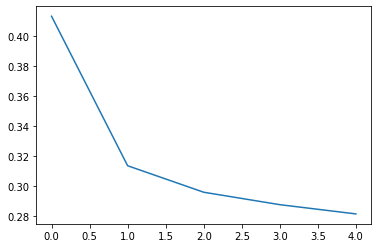

In [58]:
lr=0.1
epochs= 5
model = torch.nn.Linear(x_train.shape[1],10 ) 
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
history = []

for epoch in range(epochs):
  running_loss = 0
  for xx, yy in dataloader:
    y_hat = model(xx)
    optimizer.zero_grad()
    loss = loss_ftn(y_hat, yy)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  history.append(running_loss/len(dataloader.dataset))

plt.plot(history)

In [32]:
len(dataloader.dataset)

60000

## Example 3.1.5. Evaluation

Do the following:
* Calculate test loss.
* Calculate the train and test accuracy.

In [59]:
test_data = TensorDataset(x_test, y_test)
test_loader= DataLoader(dataset = test_data, batch_size=32, shuffle=False)

model.eval()
test_loss = 0
correct = 0
for xx, yy in test_loader:
  y_hat = model(xx)
  loss = loss_ftn(y_hat, yy)
  test_loss += loss.item()*len(xx)
  y_pred = torch.argmax(y_hat, axis=1)
  correct +=  torch.sum(yy==y_pred).item()
test_loss = test_loss/len(test_loader.dataset)
test_accuracy = correct/len(test_loader.dataset)


In [60]:
print(test_loss, test_accuracy)

0.2818851248890161 0.9232


## 3.2. Repeat the train with `train` and `evaluate` function using GPU

The following code is from Pytorch Session 2.

In [66]:
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

print(DEVICE)

cpu


In [67]:
# The following function is for batch learning in one epoch
def train(model, train_loader, optimizer, my_loss, check_interval):
  # model should be attached to the device to be used.
  # check_interval: how often you want to check the loss
  model.train() # Declair that model is in training process such as Dropout layer BatchNorm layer.
  running_loss = 0
  for batch_idx, (xx, yy) in enumerate(train_loader):
    xx = xx.to(DEVICE)
    yy = yy.to(DEVICE)
    optimizer.zero_grad()
    y_hat = model(xx)
    loss = my_loss(y_hat, yy)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
    if batch_idx % check_interval ==0:
      print("Train epoch: {} [{}/{}]".format(epoch, batch_idx*len(xx), len(train_loader.dataset)) )
  train_loss = running_loss/len(train_loader.dataset)
  print("Train epoch = {}, train loss = {}".format(epoch, train_loss))
  return train_loss


Make the similar function of `evaluation` which shows loss and accuracy for each epoch.

In [79]:
# The following function is for batch learning in one epoch
# There should be no updating parameters here!!!!!!!!
def evaluate(model, test_loader, my_loss): 
  # optimizer and check_interval are not needed here
  model.eval() # Declair that model is in test process such as Dropout layer or BatchNorm layer.
  running_loss = 0
  correct = 0
  for batch_idx, (xx, yy) in enumerate(test_loader):
    xx = xx.to(DEVICE)
    yy = yy.to(DEVICE)
    y_hat = model(xx)
    loss = my_loss(y_hat, yy)
    running_loss += loss.item()*len(xx)
    y_pred = torch.argmax(y_hat, axis=1)
    correct = correct + torch.sum(yy==y_pred).item()
  test_accuracy = correct/len(test_loader.dataset)
  test_loss = running_loss/len(test_loader.dataset)  
  return test_loss, test_accuracy

Now, start training.

In [80]:
lr=0.1
epochs= 20
model = torch.nn.Linear(x_train.shape[1],10 ).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
check_interval=200
history = []

for epoch in range(epochs):
  current_loss = train(model, dataloader, optimizer, loss_ftn, check_interval=200)
  history.append(current_loss)
  test_loss, test_accuracy = evaluate(model, test_loader, loss_ftn)
  print("[Epoch {}]: Train loss = {},      Test loss = {},  Test accuracy = {}".format(epoch, current_loss, test_loss, test_accuracy))

Train epoch: 0 [0/60000]
Train epoch: 0 [6400/60000]
Train epoch: 0 [12800/60000]
Train epoch: 0 [19200/60000]
Train epoch: 0 [25600/60000]
Train epoch: 0 [32000/60000]
Train epoch: 0 [38400/60000]
Train epoch: 0 [44800/60000]
Train epoch: 0 [51200/60000]
Train epoch: 0 [57600/60000]
Train epoch = 0, train loss = 0.4136532686312993
[Epoch 0]: Train loss = 0.4136532686312993,      Test loss = 0.3118147627413273,  Test accuracy = 0.9113
Train epoch: 1 [0/60000]
Train epoch: 1 [6400/60000]
Train epoch: 1 [12800/60000]
Train epoch: 1 [19200/60000]
Train epoch: 1 [25600/60000]
Train epoch: 1 [32000/60000]
Train epoch: 1 [38400/60000]
Train epoch: 1 [44800/60000]
Train epoch: 1 [51200/60000]
Train epoch: 1 [57600/60000]
Train epoch = 1, train loss = 0.3134818712155024
[Epoch 1]: Train loss = 0.3134818712155024,      Test loss = 0.2893595463782549,  Test accuracy = 0.9199
Train epoch: 2 [0/60000]
Train epoch: 2 [6400/60000]
Train epoch: 2 [12800/60000]
Train epoch: 2 [19200/60000]
Train epoch

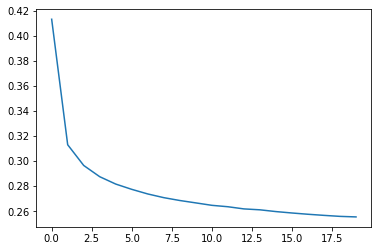

In [75]:
plt.plot(history)

In [81]:
test_loss, test_accuracy = evaluate(model, test_loader, loss_ftn)

print(test_loss, test_accuracy)

0.2769138515472412 0.9241
